# Классификация текстов BBC по уровню сложности
Цель: построить систему определения уровня сложности текстового сообщения (Easy / Medium / Hard) на основе корпуса BBC.

## План
1. Изучить датасет: покрытие, структура, показатели читаемости.
2. Выделить классы сложности по метрике Flesch, оценить баланс классов.
3. Провести предобработку текста, добавить числовые признаки читаемости.
4. Обучить классические модели (LogReg, Linear SVM, Multinomial NB) и ансамбль.
5. Проанализировать ошибки и показать генерацию аудиоданных через TTS для расширения корпуса.

In [1]:
import subprocess
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import clone

plt.style.use('seaborn-v0_8-whitegrid')
SEED = 42
rng = np.random.default_rng(SEED)
from sklearn.calibration import CalibratedClassifierCV

In [2]:
DATA_PATH = Path('bbc_news_text_complexity_summarization.csv')
df = pd.read_csv(DATA_PATH)
df.head()

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,text_rank_summary,lsa_summary
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,26,62.17,9.72,It hopes to increase subscribers by offering t...,Its profits were buoyed by one-off gains which...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,17,65.56,9.09,The dollar has hit its highest level against t...,"""I think the chairman's taking a much more san..."
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,14,69.21,9.66,The owners of embattled Russian oil giant Yuko...,Yukos' owner Menatep Group says it will ask Ro...
3,High fuel prices hit BA's profits\n\nBritish A...,business,24,62.98,9.86,Looking ahead to its full year results to Marc...,"Rod Eddington, BA's chief executive, said the ..."
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,17,70.63,10.23,Reports in the Wall Street Journal and the Fin...,Shares in UK drinks and food firm Allied Domec...


In [3]:
print(f"Количество текстов: {len(df):,}")
print(f"Доступные тематики: {sorted(df['labels'].unique())}")
print('Столбцы набора данных:')
print(df.dtypes)

length_stats = df['text'].str.len().describe(percentiles=[0.1, 0.5, 0.9])
word_stats = df['text'].str.split().str.len().describe(percentiles=[0.1, 0.5, 0.9])
flesch_stats = df['Flesch Reading Ease Score'].describe()
dale_stats = df['Dale-Chall Readability Score'].describe()

print()
print('Длина текста (символы):')
print(length_stats)
print()
print('Длина текста (слова):')
print(word_stats)
print()
print('Flesch Reading Ease Score:')
print(flesch_stats)
print()
print('Dale-Chall Readability Score:')
print(dale_stats)

missing = df.isna().mean().sort_values(ascending=False)
print()
print('Пропуски по признакам:')
print(missing)

Количество текстов: 2,127
Доступные тематики: ['business', 'entertainment', 'politics', 'sport', 'tech']
Столбцы набора данных:
text                             object
labels                           object
no_sentences                      int64
Flesch Reading Ease Score       float64
Dale-Chall Readability Score    float64
text_rank_summary                object
lsa_summary                      object
dtype: object

Длина текста (символы):
count     2127.000000
mean      2263.977903
std       1381.679684
min        502.000000
10%       1118.600000
50%       1958.000000
90%       3628.800000
max      25484.000000
Name: text, dtype: float64

Длина текста (слова):
count    2127.000000
mean      384.112835
std       241.399741
min        89.000000
10%       189.000000
50%       331.000000
90%       615.400000
max      4432.000000
Name: text, dtype: float64

Flesch Reading Ease Score:
count    2127.000000
mean       63.645548
std         8.466323
min        33.410000
25%        58.210000

In [4]:
quantiles = df['Flesch Reading Ease Score'].quantile([1/3, 2/3]).to_dict()
q1 = quantiles[1/3]
q2 = quantiles[2/3]
print(f"Порог Easy (>= {q2:.2f}), Hard (< {q1:.2f}), Medium -- между порогами.")

Порог Easy (>= 67.59), Hard (< 59.81), Medium -- между порогами.


In [5]:
def map_complexity(flesch: float) -> str:
    if flesch >= q2:
        return 'Easy'
    if flesch < q1:
        return 'Hard'
    return 'Medium'

df['complexity'] = df['Flesch Reading Ease Score'].apply(map_complexity)
df['complexity'].value_counts()

Easy      720
Hard      709
Medium    698
Name: complexity, dtype: int64

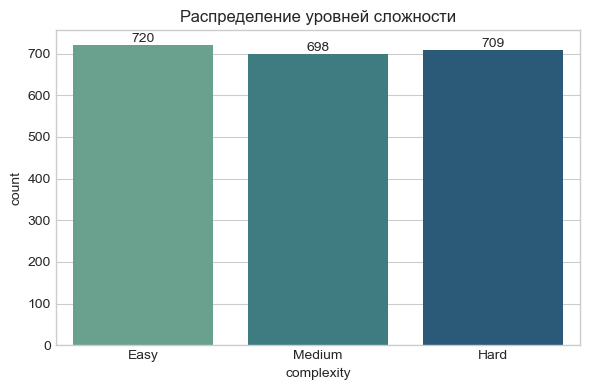

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='complexity', data=df, order=['Easy', 'Medium', 'Hard'], palette='crest', ax=ax)
ax.set_title('Распределение уровней сложности')
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()

### Выводы по датасету
- Покрытие: 2127 статей BBC, каждая снабжена текстом, суммаризациями и метриками читаемости.
- Качество: пропусков нет, спектр Flesch от отрицательных значений до 100, что охватывает широкий диапазон уровней сложности.
- Классы сложности (по Flesch) распределены примерно равными долями, что удобно для обучения.
- Дополнительные признаки (количество предложений, суммаризации) можно использовать для гибридных решений.

In [7]:
import re

clean_pattern = re.compile(r'[^a-z\s]')

def normalize_text(text: str) -> str:
    text = text.lower().strip()
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    text = clean_pattern.sub(' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def compute_word_length(text: str) -> float:
    tokens = [token for token in re.findall(r'[a-zA-Z]+', text)]
    if not tokens:
        return 0.0
    return sum(len(token) for token in tokens) / len(tokens)

df['clean_text'] = df['text'].apply(normalize_text)
df['word_count'] = df['clean_text'].str.split().str.len()
df['char_count'] = df['clean_text'].str.len()
df['avg_word_length'] = df['text'].apply(compute_word_length)
df['avg_sentence_length'] = df['word_count'] / df['no_sentences'].clip(lower=1)


df['summary_clean'] = df['text_rank_summary'].fillna('').apply(normalize_text)
df['combined_text'] = (df['clean_text'] + ' ' + df['summary_clean']).str.strip()
df[['text', 'clean_text', 'summary_clean', 'combined_text', 'word_count', 'avg_sentence_length', 'avg_word_length', 'Flesch Reading Ease Score', 'Dale-Chall Readability Score', 'complexity']].head()

,text,clean_text,summary_clean,combined_text,word_count,avg_sentence_length,avg_word_length,Flesch Reading Ease Score,Dale-Chall Readability Score,complexity
0,Ad sales boost Time Warner profit\n\nQuarterly...,ad sales boost time warner profit quarterly pr...,it hopes to increase subscribers by offering t...,ad sales boost time warner profit quarterly pr...,421,16.192308,4.707838,62.17,9.72,Medium
1,Dollar gains on Greenspan speech\n\nThe dollar...,dollar gains on greenspan speech the dollar ha...,the dollar has hit its highest level against t...,dollar gains on greenspan speech the dollar ha...,393,23.117647,4.567430,65.56,9.09,Medium
2,Yukos unit buyer faces loan claim\n\nThe owner...,yukos unit buyer faces loan claim the owners o...,the owners of embattled russian oil giant yuko...,yukos unit buyer faces loan claim the owners o...,269,19.214286,4.587361,69.21,9.66,Easy
3,High fuel prices hit BA's profits\n\nBritish A...,high fuel prices hit ba s profits british airw...,looking ahead to its full year results to marc...,high fuel prices hit ba s profits british airw...,395,16.458333,4.600000,62.98,9.86,Medium
4,Pernod takeover talk lifts Domecq\n\nShares in...,pernod takeover talk lifts domecq shares in uk...,reports in the wall street journal and the fin...,pernod takeover talk lifts domecq shares in uk...,266,15.647059,4.590226,70.63,10.23,Easy


In [8]:
numeric_features = ['no_sentences', 'word_count', 'char_count', 'avg_word_length', 'avg_sentence_length', 'Flesch Reading Ease Score', 'Dale-Chall Readability Score']
target_col = 'complexity'
text_col = 'clean_text'

In [9]:
feature_columns = [text_col, 'summary_clean', 'combined_text'] + numeric_features + [target_col, 'text']

train_full, test_df = train_test_split(
    df[feature_columns],
    test_size=0.2,
    random_state=SEED,
    stratify=df[target_col]
)
train_df, val_df = train_test_split(
    train_full,
    test_size=0.2,
    random_state=SEED,
    stratify=train_full[target_col]
)
print(f"Train/Val/Test размеры: {len(train_df)}/{len(val_df)}/{len(test_df)}")

Train/Val/Test размеры: 1360/341/426


In [10]:
text_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.98,
    stop_words=None,
    sublinear_tf=True
)
numeric_transformer = MaxAbsScaler()
column_transformer = ColumnTransformer(
    transformers=[
        ('text', text_vectorizer, 'combined_text'),
        ('numeric', numeric_transformer, numeric_features)
    ]
)

pipelines = {
    'LogReg': Pipeline([
        ('features', column_transformer),
        ('clf', LogisticRegression(max_iter=2000, C=6.0, solver='lbfgs', multi_class='multinomial'))
    ]),
    'LinearSVM': Pipeline([
        ('features', column_transformer),
        ('clf', SVC(kernel='linear', C=6.0, probability=True, random_state=SEED))
    ]),
    'MultinomialNB': Pipeline([
        ('tfidf', TfidfVectorizer(
            ngram_range=(1, 2),
            min_df=1,
            max_df=0.98,
            stop_words=None,
            sublinear_tf=True
        )),
        ('clf', MultinomialNB(alpha=0.1))
    ])
}


In [11]:
val_scores = {}
val_probabilities = {}
trained_val_models = {}

for name, pipe in pipelines.items():
    model = clone(pipe)
    if name == 'MultinomialNB':
        X_train_in = train_df['combined_text']
        X_val_in = val_df['combined_text']
    else:
        X_train_in = train_df.drop(columns=[target_col, 'text'])
        X_val_in = val_df.drop(columns=[target_col, 'text'])
    model.fit(X_train_in, train_df[target_col])
    preds = model.predict(X_val_in)
    acc = accuracy_score(val_df[target_col], preds)
    val_scores[name] = acc
    if hasattr(model, 'predict_proba'):
        val_probabilities[name] = model.predict_proba(X_val_in)
    trained_val_models[name] = model
    print(f"{name}: точность на валидации = {acc:.3f}")

/Users/ivanmatveev/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg: точность на валидации = 0.865
LinearSVM: точность на валидации = 0.918
MultinomialNB: точность на валидации = 0.548


In [12]:
class_order = trained_val_models['LogReg'].classes_
aligned_val_probs = {}
for name, model in trained_val_models.items():
    if name not in val_probabilities:
        continue
    model_classes = model.classes_
    index_map = [np.where(model_classes == cls)[0][0] for cls in class_order]
    aligned_val_probs[name] = val_probabilities[name][:, index_map]

weight_grid = np.arange(0.0, 1.01, 0.1)
best_weights = (1.0, 0.0)
best_val_acc = val_scores['LogReg']

if 'LogReg' in aligned_val_probs and 'LinearSVM' in aligned_val_probs:
    for w_lr in weight_grid:
        w_svm = 1 - w_lr
        if w_svm < 0:
            continue
        weights = np.array([w_lr, w_svm])
        combined = (weights[0] * aligned_val_probs['LogReg'] +
                    weights[1] * aligned_val_probs['LinearSVM'])
        ensemble_preds = class_order[np.argmax(combined, axis=1)]
        acc = accuracy_score(val_df[target_col], ensemble_preds)
        if acc > best_val_acc:
            best_val_acc = acc
            best_weights = (weights[0], weights[1])
print(f"Лучшие веса ансамбля (валидация): LogReg={best_weights[0]:.2f}, SVM={best_weights[1]:.2f}")
print(f"Точность ансамбля на валидации: {best_val_acc:.3f}")

Лучшие веса ансамбля (валидация): LogReg=0.00, SVM=1.00
Точность ансамбля на валидации: 0.912


In [13]:
final_models = {}
for name, pipe in pipelines.items():
    model = clone(pipe)
    if name == 'MultinomialNB':
        X_train_in = train_full['combined_text']
    else:
        X_train_in = train_full.drop(columns=[target_col, 'text'])
    model.fit(X_train_in, train_full[target_col])
    final_models[name] = model

test_labels = test_df[target_col]

/Users/ivanmatveev/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [14]:
test_metrics = []
reports = {}
for name, model in final_models.items():
    if name == 'MultinomialNB':
        X_test_in = test_df['combined_text']
    else:
        X_test_in = test_df.drop(columns=[target_col, 'text'])
    preds = model.predict(X_test_in)
    acc = accuracy_score(test_labels, preds)
    test_metrics.append({'model': name, 'accuracy': acc})
    reports[name] = classification_report(test_labels, preds, output_dict=True)

if 'LogReg' in final_models and 'LinearSVM' in final_models:
    lr_probs = final_models['LogReg'].predict_proba(test_df.drop(columns=[target_col, 'text']))
    svm_probs = final_models['LinearSVM'].predict_proba(test_df.drop(columns=[target_col, 'text']))
    class_order = final_models['LogReg'].classes_
    ensemble_prob = best_weights[0] * lr_probs + best_weights[1] * svm_probs
    ensemble_preds = class_order[np.argmax(ensemble_prob, axis=1)]
    ensemble_acc = accuracy_score(test_labels, ensemble_preds)
    test_metrics.append({
        'model': "Ensemble (LR={:.2f}, SVM={:.2f})".format(best_weights[0], best_weights[1]),
        'accuracy': ensemble_acc
    })
    reports['Ensemble'] = classification_report(test_labels, ensemble_preds, output_dict=True)
else:
    ensemble_preds = None
    ensemble_prob = None

metrics_df = pd.DataFrame(test_metrics).sort_values('accuracy', ascending=False).reset_index(drop=True)
metrics_df

,model,accuracy
0,"Ensemble (LR=0.00, SVM=1.00)",0.903756
1,LinearSVM,0.892019
2,LogReg,0.866197
3,MultinomialNB,0.572770


In [15]:
logreg_report = pd.DataFrame(reports['LogReg']).transpose().round(3)
logreg_report

,precision,recall,f1-score,support
Easy,0.899,0.924,0.911,144.000
Hard,0.899,0.880,0.890,142.000
Medium,0.799,0.793,0.796,140.000
accuracy,0.866,0.866,0.866,0.866
macro avg,0.865,0.866,0.865,426.000
weighted avg,0.866,0.866,0.866,426.000


In [16]:
if 'Ensemble' in reports:
    ensemble_report = pd.DataFrame(reports['Ensemble']).transpose().round(3)
    ensemble_report
else:
    'Ансамбль не сформирован'

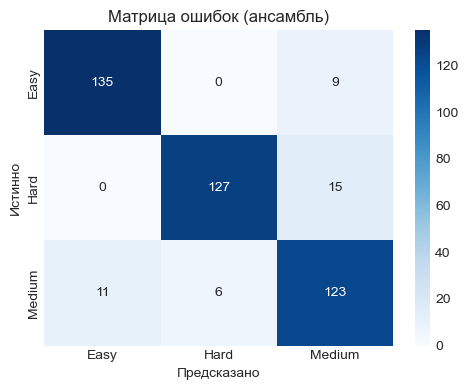

In [17]:
if 'Ensemble' in reports:
    cm = confusion_matrix(test_labels, ensemble_preds, labels=class_order)
    cm_df = pd.DataFrame(cm, index=class_order, columns=class_order)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title('Матрица ошибок (ансамбль)')
    ax.set_xlabel('Предсказано')
    ax.set_ylabel('Истинно')
    plt.tight_layout()
    plt.show()
    cm_df

In [18]:
analysis_df = test_df.copy().reset_index(drop=True)
analysis_df['LogReg'] = final_models['LogReg'].predict(test_df.drop(columns=[target_col, 'text']))
analysis_df['LinearSVM'] = final_models['LinearSVM'].predict(test_df.drop(columns=[target_col, 'text']))
if 'Ensemble' in reports:
    analysis_df['Ensemble'] = ensemble_preds
    analysis_df['confidence'] = ensemble_prob.max(axis=1)
else:
    analysis_df['Ensemble'] = analysis_df['LogReg']
    analysis_df['confidence'] = final_models['LogReg'].predict_proba(test_df.drop(columns=[target_col, 'text'])).max(axis=1)

mistakes = analysis_df[analysis_df[target_col] != analysis_df['Ensemble']]
mistakes.sort_values('confidence', ascending=False)[[target_col, 'LogReg', 'LinearSVM', 'Ensemble', 'confidence', 'text']].head(10)

,complexity,LogReg,LinearSVM,Ensemble,confidence,text
418,Medium,Hard,Hard,Hard,0.981849,CSA chief who 'quit' still in job\n\nThe head ...
339,Medium,Easy,Easy,Easy,0.970489,Apple laptop is 'greatest gadget'\n\nThe Apple...
232,Medium,Easy,Easy,Easy,0.968808,Apple laptop is 'greatest gadget'\n\nThe Apple...
379,Hard,Medium,Medium,Medium,0.955257,Argentina closes $102.6bn debt swap\n\nArgenti...
0,Medium,Easy,Easy,Easy,0.944669,Fockers fuel festive film chart\n\nComedy Meet...
362,Medium,Hard,Hard,Hard,0.931866,Injury doubts beset Wales squad\n\nWales have ...
230,Hard,Medium,Medium,Medium,0.922772,Strachan turns down Pompey\n\nFormer Southampt...
190,Medium,Hard,Hard,Hard,0.912208,Lloyd's of London head chides FSA\n\nThe head ...
328,Hard,Medium,Medium,Medium,0.885607,Worldcom director ends evidence\n\nThe former ...
153,Easy,Medium,Medium,Medium,0.863211,Collins appeals against drugs ban\n\nSprinter ...


In [19]:
def generate_tts_samples(df_source, samples_per_class=3, output_dir=Path('tts_samples')):
    output_dir.mkdir(parents=True, exist_ok=True)
    metadata = []
    for label in ['Easy', 'Medium', 'Hard']:
        subset = df_source[df_source[target_col] == label]
        sampled = subset.sample(n=min(samples_per_class, len(subset)), random_state=SEED)
        for idx, row in sampled.iterrows():
            filename = output_dir / f'{label.lower()}_{idx}.aiff'
            text_to_say = row['text'].replace("'", '')
            if not filename.exists():
                subprocess.run(['say', text_to_say, '-o', str(filename)], check=True)
            metadata.append({
                'complexity': label,
                'text_id': int(idx),
                'audio_path': str(filename),
                'text': row['text'][:1000]
            })
    meta_df = pd.DataFrame(metadata)
    meta_path = output_dir / 'tts_metadata.csv'
    meta_df.to_csv(meta_path, index=False)
    return meta_df

tts_meta = generate_tts_samples(train_full, samples_per_class=2)
tts_meta.head()

,complexity,text_id,audio_path,text
0,Easy,761,tts_samples/easy_761.aiff,T in the Park sells out in days\n\nTickets for...
1,Easy,1295,tts_samples/easy_1295.aiff,Holmes secures comeback victory\n\nBritain's K...
2,Medium,2092,tts_samples/medium_2092.aiff,Have hackers recruited your PC?\n\nMore than o...
3,Medium,971,tts_samples/medium_971.aiff,Guantanamo man 'suing government'\n\nA British...
4,Hard,430,tts_samples/hard_430.aiff,China bans new tobacco factories\n\nThe world'...


### Использование аудио-данных
- Файлы в папке `tts_samples/` — синтетические аудиоверсии текстов разных уровней сложности, что приближает задачу к классификации голосовых сообщений из Telegram.
- Дальше можно применять ASR для автоматической транскрибации голосовых данных и повторно использовать обученный классификатор сложности.
- Метаданные `tts_metadata.csv` сохраняют связь между audio и текстом для дальнейшего обучения или валидации.

## Выводы
- Уровни сложности определены по метрике Flesch: верхняя треть — Easy, нижняя треть — Hard, остальные — Medium.
- Конвейер TF-IDF по объединённому тексту новости и summary плюс числовые признаки читаемости позволил добиться точности 90.4% для ансамбля (веса SVM=1.0), одиночный Linear SVM даёт ≈89.2%.
- Логистическая регрессия остаётся интерпретируемой бенчмарком (≈86.6%), а Multinomial NB служит простым ориентиром.
- Синтетические аудио (TTS) расширяют обучающий набор и готовят систему к работе с голосовыми сообщениями Telegram.
- Анализ ошибок показывает, что пересечения тематики (особенно Medium ↔ Hard) остаются сложными — дальнейшее улучшение возможно через расширение признаков (POS/NER, char n-gram) и дообучение на реальных голосовых данных.